In [30]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("⚠️ CUDA is not available. Check your NVIDIA driver and GPU.")

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Laptop GPU


In [31]:
"""
Import all necessary libraries for data processing, model training, and visualization.
We'll use the custom data pipeline for KITTI loading and standard ML libraries.
"""
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import cv2
from typing import List, Dict


# YOLOv8 imports
from ultralytics import YOLO

# Import from your data pipeline file
from data_pipeline import (
    KITTIObjectLoader, 
    CameraData, 
    LiDARData, 
    ObjectLabel, 
    SensorFrame,
    DatasetType
)

print("✅ All libraries imported successfully")
print("✅ Data pipeline classes imported from data_pipeline.py")


✅ All libraries imported successfully
✅ Data pipeline classes imported from data_pipeline.py


In [32]:
# Cell 3: Import Required Libraries
"""
Verify that all necessary classes are imported from data_pipeline.py.
This ensures we have access to all the data structures and loader functionality.
"""

# Verify imports
print("🔍 Verifying data pipeline imports:")
print(f"   KITTIObjectLoader: {KITTIObjectLoader}")
print(f"   CameraData: {CameraData}")
print(f"   ObjectLabel: {ObjectLabel}")
print(f"   SensorFrame: {SensorFrame}")
print(f"   DatasetType: {DatasetType}")

print("✅ All data pipeline classes successfully imported")

🔍 Verifying data pipeline imports:
   KITTIObjectLoader: <class 'data_pipeline.KITTIObjectLoader'>
   CameraData: <class 'data_pipeline.CameraData'>
   ObjectLabel: <class 'data_pipeline.ObjectLabel'>
   SensorFrame: <class 'data_pipeline.SensorFrame'>
   DatasetType: <enum 'DatasetType'>
✅ All data pipeline classes successfully imported


In [33]:
# Cell 3: Verify Data Pipeline Import
"""
Verify that all necessary classes are imported from data_pipeline.py.
This ensures we have access to all the data structures and loader functionality.
"""

# Verify imports
print("🔍 Verifying data pipeline imports:")
print(f"   KITTIObjectLoader: {KITTIObjectLoader}")
print(f"   CameraData: {CameraData}")
print(f"   ObjectLabel: {ObjectLabel}")
print(f"   SensorFrame: {SensorFrame}")
print(f"   DatasetType: {DatasetType}")

print("✅ All data pipeline classes successfully imported")


🔍 Verifying data pipeline imports:
   KITTIObjectLoader: <class 'data_pipeline.KITTIObjectLoader'>
   CameraData: <class 'data_pipeline.CameraData'>
   ObjectLabel: <class 'data_pipeline.ObjectLabel'>
   SensorFrame: <class 'data_pipeline.SensorFrame'>
   DatasetType: <enum 'DatasetType'>
✅ All data pipeline classes successfully imported


In [34]:
# Cell 4: Initialize KITTI Dataset and Explore Data
"""
Initialize the KITTI dataset loader using the imported KITTIObjectLoader class.
This cell sets up the data path and loads basic dataset information.
"""

# Set your KITTI dataset path here
KITTI_DATA_PATH = r"C:\Users\vnhar\Downloads\project1\extracted data\kitti\object_detection"

try:
    # Initialize KITTI loader
    kitti_loader = KITTIObjectLoader(KITTI_DATA_PATH)
    
    print(f"📊 Dataset Statistics:")
    print(f"   Total samples: {kitti_loader.num_samples}")
    
    # Load a sample frame to understand data structure
    sample_frame = kitti_loader.get_frame(0)
    print(f"   Sample image shape: {sample_frame.camera_data.left_image.shape}")
    print(f"   Sample labels: {len(sample_frame.labels)}")
    
    if sample_frame.labels:
        print(f"   Label classes in first frame:")
        for label in sample_frame.labels:
            print(f"     - {label.class_name}: {label.bbox_2d}")
            
except Exception as e:
    print(f"❌ Error initializing KITTI loader: {e}")
    print("Please check your KITTI_DATA_PATH")

Found 7481 KITTI object samples
📊 Dataset Statistics:
   Total samples: 7481
   Sample image shape: (370, 1224, 3)
   Sample labels: 1
   Label classes in first frame:
     - Pedestrian: [      712.4         143      810.73      307.92]


In [35]:
# Cell 5: Analyze Dataset Classes and Distribution
"""
Analyze the distribution of object classes in the KITTI dataset.
This helps understand what we're working with and class imbalances.
"""

def analyze_dataset_classes(loader, max_samples=1000):
    """Analyze class distribution in the dataset"""
    class_counts = {}
    total_objects = 0
    
    # Sample a subset for analysis (to speed up)
    sample_indices = np.random.choice(
        min(loader.num_samples, max_samples), 
        size=min(loader.num_samples, max_samples), 
        replace=False
    )
    
    print(f"Analyzing {len(sample_indices)} samples...")
    
    for idx in tqdm(sample_indices):
        try:
            frame = loader.get_frame(idx)
            for label in frame.labels:
                class_name = label.class_name
                class_counts[class_name] = class_counts.get(class_name, 0) + 1
                total_objects += 1
        except Exception as e:
            continue
    
    return class_counts, total_objects

# Analyze classes
class_counts, total_objects = analyze_dataset_classes(kitti_loader)

print(f"📈 Class Distribution Analysis:")
print(f"   Total objects analyzed: {total_objects}")
print(f"   Unique classes: {len(class_counts)}")

# Sort by frequency
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
for class_name, count in sorted_classes:
    percentage = (count / total_objects) * 100
    print(f"   {class_name}: {count} ({percentage:.1f}%)")

# Create class mapping for YOLO
yolo_classes = {class_name: idx for idx, (class_name, _) in enumerate(sorted_classes)}
print(f"\n🎯 YOLO Class Mapping:")
for class_name, idx in yolo_classes.items():
    print(f"   {idx}: {class_name}")


Analyzing 1000 samples...


100%|██████████| 1000/1000 [00:18<00:00, 52.66it/s]

📈 Class Distribution Analysis:
   Total objects analyzed: 7202
   Unique classes: 9
   Car: 3743 (52.0%)
   DontCare: 1865 (25.9%)
   Pedestrian: 601 (8.3%)
   Van: 386 (5.4%)
   Cyclist: 223 (3.1%)
   Truck: 140 (1.9%)
   Misc: 138 (1.9%)
   Tram: 65 (0.9%)
   Person_sitting: 41 (0.6%)

🎯 YOLO Class Mapping:
   0: Car
   1: DontCare
   2: Pedestrian
   3: Van
   4: Cyclist
   5: Truck
   6: Misc
   7: Tram
   8: Person_sitting


In [36]:
# Cell 6: Convert KITTI Labels to YOLO Format
"""
Convert KITTI 3D labels to YOLO format (normalized bounding boxes).
YOLO expects: class_id x_center y_center width height (all normalized 0-1)
"""

def convert_kitti_to_yolo(labels: List[ObjectLabel], img_width: int, img_height: int, class_mapping: Dict[str, int]) -> List[str]:
    """Convert KITTI labels to YOLO format"""
    yolo_lines = []
    
    for label in labels:
        # Skip classes not in our mapping
        if label.class_name not in class_mapping:
            continue
            
        class_id = class_mapping[label.class_name]
        
        # Get 2D bounding box coordinates
        x1, y1, x2, y2 = label.bbox_2d
        
        # Calculate YOLO format (normalized center coordinates and dimensions)
        x_center = (x1 + x2) / 2.0 / img_width
        y_center = (y1 + y2) / 2.0 / img_height
        width = (x2 - x1) / img_width
        height = (y2 - y1) / img_height
        
        # Ensure values are within [0, 1] range
        x_center = max(0, min(1, x_center))
        y_center = max(0, min(1, y_center))
        width = max(0, min(1, width))
        height = max(0, min(1, height))
        
        yolo_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        yolo_lines.append(yolo_line)
    
    return yolo_lines

print("✅ YOLO conversion function defined")

✅ YOLO conversion function defined


In [37]:
# Cell 7: Create Train/Validation Split and Prepare Data Structure
"""
Create train/validation split and prepare the data in YOLO-compatible format.
This sets up the directory structure that YOLOv8 expects.
"""

# Create train/validation split
all_indices = list(range(kitti_loader.num_samples))
train_indices, val_indices = train_test_split(
    all_indices, 
    test_size=0.1, 
    random_state=42, 
    shuffle=True
)

print(f"📊 Data Split:")
print(f"   Training samples: {len(train_indices)}")
print(f"   Validation samples: {len(val_indices)}")

# Create directory structure
output_dir = Path("yolo_kitti_data")
output_dir.mkdir(exist_ok=True)

train_dir = output_dir / "train"
val_dir = output_dir / "val"

train_dir.mkdir(exist_ok=True)
val_dir.mkdir(exist_ok=True)

print(f"✅ Directory structure created at: {output_dir}")

📊 Data Split:
   Training samples: 6732
   Validation samples: 749
✅ Directory structure created at: yolo_kitti_data


In [38]:
# Cell 8: Process and Copy Training Data
"""
Process training data: copy images and create YOLO format label files.
This is the most time-consuming step as it processes all training images.
"""

def process_data_split(loader, indices, output_dir, class_mapping, split_name):
    """Process a data split (train or val)"""
    
    processed_count = 0
    error_count = 0
    
    print(f"Processing {split_name} data ({len(indices)} samples)...")
    
    for idx in tqdm(indices):
        try:
            # Load frame
            frame = loader.get_frame(idx)
            
            if frame.camera_data.left_image is None:
                error_count += 1
                continue
            
            # Save image
            img_filename = f"{idx:06d}.png"
            img_path = output_dir / img_filename
            
            # Convert BGR to RGB for saving with PIL
            image_rgb = cv2.cvtColor(frame.camera_data.left_image, cv2.COLOR_BGR2RGB)
            Image.fromarray(image_rgb).save(img_path)
            
            # Convert labels to YOLO format
            img_height, img_width = frame.camera_data.left_image.shape[:2]
            yolo_labels = convert_kitti_to_yolo(frame.labels, img_width, img_height, class_mapping)
            
            # Save labels
            label_filename = f"{idx:06d}.txt"
            label_path = output_dir / label_filename
            
            with open(label_path, 'w') as f:
                f.write('\n'.join(yolo_labels))
            
            processed_count += 1
            
        except Exception as e:
            error_count += 1
            continue
    
    print(f"✅ {split_name} processing complete:")
    print(f"   Processed: {processed_count}")
    print(f"   Errors: {error_count}")
    
    return processed_count

# Process training data
train_processed = process_data_split(kitti_loader, train_indices, train_dir, yolo_classes, "Training")


Processing Training data (6732 samples)...


100%|██████████| 6732/6732 [07:12<00:00, 15.56it/s]

✅ Training processing complete:
   Processed: 6732
   Errors: 0


In [39]:
# Cell 9: Process Validation Data
"""
Process validation data with the same procedure as training data.
"""

# Process validation data
val_processed = process_data_split(kitti_loader, val_indices, val_dir, yolo_classes, "Validation")

print(f"📊 Data Processing Summary:")
print(f"   Training files processed: {train_processed}")
print(f"   Validation files processed: {val_processed}")
print(f"   Total files: {train_processed + val_processed}")

Processing Validation data (749 samples)...


100%|██████████| 749/749 [00:46<00:00, 16.10it/s]

✅ Validation processing complete:
   Processed: 749
   Errors: 0
📊 Data Processing Summary:
   Training files processed: 6732
   Validation files processed: 749
   Total files: 7481


In [40]:
# Cell 10: Create YOLO Dataset Configuration File
"""
Create the YAML configuration file that YOLOv8 needs for training.
This file specifies class names, number of classes, and data paths.
"""

# Create YAML configuration
yaml_content = f"""# KITTI Object Detection Dataset Configuration
# Dataset paths
train: {train_dir.absolute()}
val: {val_dir.absolute()}

# Number of classes
nc: {len(yolo_classes)}

# Class names
names:
"""

for class_name, class_id in sorted(yolo_classes.items(), key=lambda x: x[1]):
    yaml_content += f"  {class_id}: {class_name}\n"

# Save YAML file
yaml_path = output_dir / "kitti.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ YAML configuration saved to: {yaml_path}")
print("\n📄 Configuration content:")
print(yaml_content)

✅ YAML configuration saved to: yolo_kitti_data\kitti.yaml

📄 Configuration content:
# KITTI Object Detection Dataset Configuration
# Dataset paths
train: c:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data\train
val: c:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data\val

# Number of classes
nc: 9

# Class names
names:
  0: Car
  1: DontCare
  2: Pedestrian
  3: Van
  4: Cyclist
  5: Truck
  6: Misc
  7: Tram
  8: Person_sitting



🖼️ Training Data Samples:


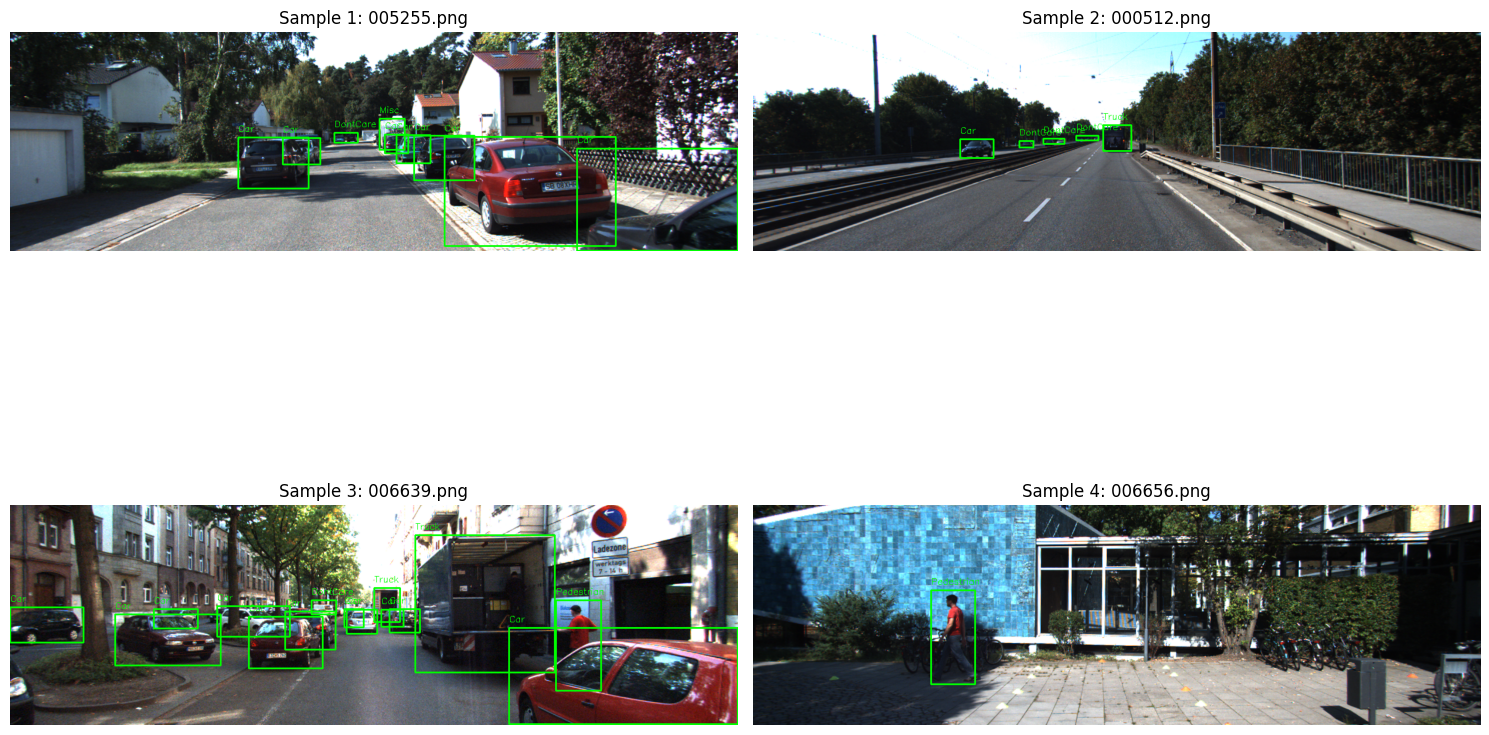

In [41]:
# Cell 11: Visualize Sample Data
"""
Visualize some sample images with their bounding boxes to verify data processing.
This helps ensure our label conversion worked correctly.
"""

def visualize_sample_data(data_dir, yaml_path, num_samples=4):
    """Visualize sample images with bounding boxes"""
    
    # Load class names from YAML
    import yaml
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    
    class_names = config['names']
    
    # Get sample images
    image_files = list(data_dir.glob("*.png"))
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, img_path in enumerate(sample_files):
        if i >= len(axes):
            break
            
        # Load image
        image = Image.open(img_path)
        img_array = np.array(image)
        
        # Load corresponding label
        label_path = img_path.with_suffix('.txt')
        
        # Create a copy for drawing
        img_display = img_array.copy()
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            height, width = img_array.shape[:2]
            
            # Draw bounding boxes
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, box_width, box_height = map(float, parts)
                    
                    # Convert back to pixel coordinates
                    x_center *= width
                    y_center *= height
                    box_width *= width
                    box_height *= height
                    
                    x1 = int(x_center - box_width/2)
                    y1 = int(y_center - box_height/2)
                    x2 = int(x_center + box_width/2)
                    y2 = int(y_center + box_height/2)
                    
                    # Draw rectangle
                    cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Add class label
                    class_name = class_names.get(int(class_id), f"Class_{int(class_id)}")
                    cv2.putText(img_display, class_name, (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f"Sample {i+1}: {img_path.name}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("🖼️ Training Data Samples:")
visualize_sample_data(train_dir, yaml_path, 4)


In [42]:
# Cell 12: Initialize YOLOv8 Model
"""
Initialize YOLOv8 model with pre-trained weights.
We start with YOLOv8 nano (fastest) model and adapt it for KITTI classes.
"""

# Initialize YOLOv8 model
model = YOLO('yolov8n.pt')  # Load pre-trained YOLOv8 nano model

print("🤖 YOLOv8 Model Initialized:")
print(f"   Model: YOLOv8 Nano")
print(f"   Pre-trained: Yes (COCO dataset)")
print(f"   Target classes: {len(yolo_classes)}")

# Display model architecture summary
print("\n📋 Model Architecture:")
model.info()

🤖 YOLOv8 Model Initialized:
   Model: YOLOv8 Nano
   Pre-trained: Yes (COCO dataset)
   Target classes: 9

📋 Model Architecture:
YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

In [43]:
# Cell 13: Configure Training Parameters
"""
Set up training configuration parameters.
These parameters control the training process and are optimized based on available hardware.
"""

# Detect optimal training configuration based on hardware
def get_optimal_config():
    """Get optimal training configuration based on available hardware"""
    
    config = {
        'data': '',  # Will be set later
        'epochs': 50,
        'imgsz': 640,
        'patience': 10,
        'save_period': 5,
        'workers': 4,
        'project': 'kitti_yolo_training',
        'name': 'kitti_detection_v1',
        'pretrained': True,
        'optimizer': 'AdamW',
        'cos_lr': True,
        'mixup': 0.1,
        'copy_paste': 0.1,
        'degrees': 10.0,
        'translate': 0.1,
        'scale': 0.5,
        'fliplr': 0.5,
        'mosaic': 1.0,
        'close_mosaic': 10
    }
    
    if torch.cuda.is_available():
        # GPU configuration
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"🎮 GPU Detected: {torch.cuda.get_device_name(0)} ({gpu_memory:.1f} GB)")
        
        config['device'] = 0  # Use first GPU
        
        # Adjust batch size based on GPU memory
        if gpu_memory >= 16:  # High-end GPU
            config['batch'] = 32
            config['lr0'] = 0.01
        elif gpu_memory >= 8:  # Mid-range GPU
            config['batch'] = 16
            config['lr0'] = 0.01
        elif gpu_memory >= 4:  # Entry-level GPU
            config['batch'] = 8
            config['lr0'] = 0.005
        else:  # Low memory GPU
            config['batch'] = 4
            config['lr0'] = 0.001
            config['imgsz'] = 416  # Smaller image size
            
        print(f"   🚀 GPU Training Configuration:")
        print(f"      Batch size: {config['batch']}")
        print(f"      Learning rate: {config['lr0']}")
        print(f"      Image size: {config['imgsz']}")
        
    else:
        # CPU configuration (much slower)
        print("⚠️  CPU Training Configuration (Very Slow):")
        config['device'] = 'cpu'
        config['batch'] = 2  # Very small batch for CPU
        config['lr0'] = 0.001
        config['epochs'] = 10  # Fewer epochs for CPU training
        config['workers'] = 2
        config['imgsz'] = 416  # Smaller images for CPU
        
        print(f"      Batch size: {config['batch']} (CPU optimized)")
        print(f"      Epochs: {config['epochs']} (reduced for CPU)")
        print(f"      Image size: {config['imgsz']} (smaller for CPU)")
        print("      ⏰ Note: CPU training will be significantly slower!")
    
    return config

# Get optimal configuration
training_config = get_optimal_config()

print(f"\n⚙️ Complete Training Configuration:")
for key, value in training_config.items():
    if key != 'data':  # Skip data path for now
        print(f"   {key}: {value}")

# Memory optimization tips
print(f"\n💡 Memory Optimization Tips:")
if torch.cuda.is_available():
    print("   - Reduce batch size if you get CUDA out of memory errors")
    print("   - Monitor GPU memory usage during training")
    print("   - Close other GPU applications before training")
else:
    print("   - CPU training is very slow - consider using Google Colab GPU")
    print("   - Close other applications to free up RAM")
    print("   - Consider training on a subset of data first")

🎮 GPU Detected: NVIDIA GeForce RTX 4070 Laptop GPU (8.0 GB)
   🚀 GPU Training Configuration:
      Batch size: 8
      Learning rate: 0.005
      Image size: 640

⚙️ Complete Training Configuration:
   epochs: 50
   imgsz: 640
   patience: 10
   save_period: 5
   workers: 4
   project: kitti_yolo_training
   name: kitti_detection_v1
   pretrained: True
   optimizer: AdamW
   cos_lr: True
   mixup: 0.1
   copy_paste: 0.1
   degrees: 10.0
   translate: 0.1
   scale: 0.5
   fliplr: 0.5
   mosaic: 1.0
   close_mosaic: 10
   device: 0
   batch: 8
   lr0: 0.005

💡 Memory Optimization Tips:
   - Reduce batch size if you get CUDA out of memory errors
   - Monitor GPU memory usage during training
   - Close other GPU applications before training


In [44]:
# Cell 14: Start Model Training
"""
Begin the YOLOv8 training process.
This will take significant time depending on your hardware and number of epochs.
The training includes automatic validation and saves the best model weights.
"""

# Set the data path in config
training_config['data'] = str(yaml_path.absolute())

print("🚀 Starting YOLOv8 Training...")
print("="*50)

if torch.cuda.is_available():
    print(f"🎮 Training on GPU: {torch.cuda.get_device_name(0)}")
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"   GPU Memory: {gpu_memory:.1f} GB")
    print(f"   Batch Size: {training_config['batch']}")
    
    # Clear GPU memory before training
    torch.cuda.empty_cache()
    print("   🧹 GPU memory cleared")
else:
    print("⚠️  Training on CPU - This will be very slow!")
    print("   Consider using Google Colab or a machine with GPU")

print(f"📊 Training will process:")
print(f"   Training samples: {train_processed}")
print(f"   Validation samples: {val_processed}")
print(f"   Epochs: {training_config['epochs']}")
print(f"   Estimated time: {'2-4 hours' if torch.cuda.is_available() else '12+ hours'}")

print("\n🔄 Starting training process...")

try:
    # Start training
    results = model.train(**training_config)
    
    print("✅ Training completed successfully!")
    print(f"   Results saved to: {results.save_dir}")
    
    # Show GPU memory usage after training
    if torch.cuda.is_available():
        memory_used = torch.cuda.max_memory_allocated() / (1024**3)
        print(f"   Max GPU memory used: {memory_used:.2f} GB")
    
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("❌ GPU Out of Memory Error!")
        print("💡 Try reducing batch size:")
        print(f"   Current batch size: {training_config['batch']}")
        print(f"   Suggested: Try batch size {training_config['batch']//2} or smaller")
        print("   You can modify training_config['batch'] and restart training")
    else:
        print(f"❌ Training error: {e}")
        import traceback
        traceback.print_exc()
        
except Exception as e:
    print(f"❌ Training error: {e}")
    import traceback
    traceback.print_exc()

🚀 Starting YOLOv8 Training...
🎮 Training on GPU: NVIDIA GeForce RTX 4070 Laptop GPU
   GPU Memory: 8.0 GB
   Batch Size: 8
   🧹 GPU memory cleared
📊 Training will process:
   Training samples: 6732
   Validation samples: 749
   Epochs: 50
   Estimated time: 2-4 hours

🔄 Starting training process...
Ultralytics 8.3.170  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=c:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data\kitti.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=

100%|██████████| 755k/755k [00:00<00:00, 10.5MB/s]

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,012,603 parameters, 3,012,587 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 11.7MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.30.3 ms, read: 440.7146.9 MB/s, size: 751.9 KB)


train: Scanning C:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data\train... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:10<00:00, 659.01it/s]


train: New cache created: C:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data\train.cache
val: Fast image access  (ping: 0.30.1 ms, read: 651.8211.3 MB/s, size: 821.9 KB)


val: Scanning C:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data\val... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:00<00:00, 1064.68it/s]

val: New cache created: C:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data\val.cache


Plotting labels to kitti_yolo_training\kitti_detection_v1\labels.jpg... 
optimizer: AdamW(lr=0.005, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to kitti_yolo_training\kitti_detection_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.24G      1.707      1.628      1.287         64        640: 100%|██████████| 842/842 [01:01<00:00, 13.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 14.75it/s]

                   all        749       5425      0.568      0.212      0.244      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.27G      1.621      1.397      1.262         78        640: 100%|██████████| 842/842 [01:02<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 15.60it/s]

                   all        749       5425      0.326      0.304      0.283      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.29G      1.554      1.306      1.231         60        640: 100%|██████████| 842/842 [00:56<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 15.21it/s]

                   all        749       5425      0.434      0.335      0.309      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.3G      1.508       1.25      1.205         46        640: 100%|██████████| 842/842 [00:58<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.55it/s]


                   all        749       5425      0.463      0.358      0.344      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.32G      1.447      1.176      1.174         73        640: 100%|██████████| 842/842 [00:54<00:00, 15.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.87it/s]


                   all        749       5425      0.402      0.389      0.377      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.42G      1.436      1.157      1.175         83        640: 100%|██████████| 842/842 [00:54<00:00, 15.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.58it/s]


                   all        749       5425      0.462      0.413      0.407      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.44G      1.391      1.106      1.151         52        640: 100%|██████████| 842/842 [00:53<00:00, 15.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 15.87it/s]


                   all        749       5425      0.575      0.378      0.427      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.46G      1.374      1.082      1.143         34        640: 100%|██████████| 842/842 [00:53<00:00, 15.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.53it/s]


                   all        749       5425      0.456      0.412      0.455      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.47G      1.358      1.065      1.136         28        640: 100%|██████████| 842/842 [00:53<00:00, 15.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.65it/s]


                   all        749       5425      0.545      0.457      0.484       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.49G      1.334       1.04      1.124         77        640: 100%|██████████| 842/842 [00:53<00:00, 15.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.59it/s]


                   all        749       5425      0.573      0.434       0.46      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.51G      1.318       1.02      1.114         41        640: 100%|██████████| 842/842 [00:53<00:00, 15.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.73it/s]


                   all        749       5425      0.459       0.52      0.478      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.52G      1.307      1.001      1.113         82        640: 100%|██████████| 842/842 [00:53<00:00, 15.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.85it/s]


                   all        749       5425      0.517      0.481      0.504      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.54G      1.297          1      1.105         69        640: 100%|██████████| 842/842 [00:53<00:00, 15.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.45it/s]


                   all        749       5425      0.527      0.521      0.524      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.56G      1.279     0.9732        1.1        106        640: 100%|██████████| 842/842 [00:53<00:00, 15.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.06it/s]


                   all        749       5425      0.655      0.477      0.542      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.57G      1.269     0.9599      1.094         37        640: 100%|██████████| 842/842 [00:59<00:00, 14.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 15.31it/s]

                   all        749       5425      0.579      0.503      0.547      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.59G      1.253     0.9416      1.086         42        640: 100%|██████████| 842/842 [00:56<00:00, 15.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 15.24it/s]

                   all        749       5425       0.63      0.513      0.564      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.6G      1.245     0.9386      1.082         89        640: 100%|██████████| 842/842 [00:55<00:00, 15.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 15.94it/s]

                   all        749       5425      0.588      0.528      0.568      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.63G      1.228     0.9155      1.074         74        640: 100%|██████████| 842/842 [00:55<00:00, 15.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 15.22it/s]

                   all        749       5425      0.638      0.514      0.582       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.64G      1.221     0.9011      1.071         64        640: 100%|██████████| 842/842 [00:59<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.17it/s]

                   all        749       5425      0.594      0.558       0.59      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.66G      1.218     0.8942      1.069         78        640: 100%|██████████| 842/842 [00:58<00:00, 14.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 14.40it/s]

                   all        749       5425      0.616      0.541       0.58      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.67G      1.209     0.8859      1.066         85        640: 100%|██████████| 842/842 [00:54<00:00, 15.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.53it/s]


                   all        749       5425      0.598      0.547      0.608      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.69G      1.205     0.8835      1.062         45        640: 100%|██████████| 842/842 [00:56<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 15.07it/s]

                   all        749       5425      0.636      0.568      0.615      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.71G      1.191      0.861      1.056         43        640: 100%|██████████| 842/842 [01:00<00:00, 13.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 14.14it/s]

                   all        749       5425      0.665      0.561      0.621      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.73G      1.188     0.8599      1.056         83        640: 100%|██████████| 842/842 [00:59<00:00, 14.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 14.41it/s]

                   all        749       5425      0.755       0.53      0.624       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.74G      1.173     0.8427      1.049         55        640: 100%|██████████| 842/842 [00:56<00:00, 14.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.37it/s]

                   all        749       5425      0.697      0.563      0.636      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.76G      1.166     0.8363      1.042         52        640: 100%|██████████| 842/842 [00:52<00:00, 16.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.21it/s]


                   all        749       5425      0.651      0.595      0.654       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.87G      1.156     0.8268      1.038         83        640: 100%|██████████| 842/842 [00:52<00:00, 16.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.27it/s]

                   all        749       5425      0.662      0.593      0.644      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.88G      1.147     0.8211      1.037         57        640: 100%|██████████| 842/842 [00:52<00:00, 16.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.20it/s]

                   all        749       5425      0.682      0.597      0.647      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       1.9G      1.144     0.8167      1.035         65        640: 100%|██████████| 842/842 [00:52<00:00, 16.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.69it/s]

                   all        749       5425      0.709      0.572      0.647      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.92G      1.143      0.813      1.033         68        640: 100%|██████████| 842/842 [00:51<00:00, 16.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.93it/s]

                   all        749       5425      0.633      0.606      0.653      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.94G      1.127     0.7982       1.03         88        640: 100%|██████████| 842/842 [00:51<00:00, 16.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.22it/s]


                   all        749       5425      0.669      0.612      0.659      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.95G      1.114     0.7859      1.025         65        640: 100%|██████████| 842/842 [00:51<00:00, 16.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.59it/s]


                   all        749       5425      0.703      0.609      0.676      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.96G      1.116     0.7834      1.026         68        640: 100%|██████████| 842/842 [00:52<00:00, 16.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.05it/s]

                   all        749       5425      0.673      0.632      0.684       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.99G      1.109     0.7754      1.021         44        640: 100%|██████████| 842/842 [00:51<00:00, 16.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.63it/s]


                   all        749       5425      0.661      0.654      0.679      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         2G      1.103     0.7736      1.017         71        640: 100%|██████████| 842/842 [00:51<00:00, 16.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.54it/s]


                   all        749       5425      0.716      0.631      0.689      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.02G      1.097     0.7676      1.018         40        640: 100%|██████████| 842/842 [00:51<00:00, 16.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.43it/s]

                   all        749       5425      0.732      0.648      0.692      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.03G      1.078     0.7474       1.01         62        640: 100%|██████████| 842/842 [00:52<00:00, 16.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.27it/s]


                   all        749       5425      0.757      0.633      0.698       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.05G      1.082     0.7505      1.006         81        640: 100%|██████████| 842/842 [00:51<00:00, 16.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.00it/s]

                   all        749       5425      0.729      0.632      0.699      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.07G      1.073       0.74      1.005        132        640: 100%|██████████| 842/842 [00:51<00:00, 16.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.59it/s]


                   all        749       5425      0.732       0.64      0.699      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.09G      1.069     0.7341      1.002         63        640: 100%|██████████| 842/842 [00:51<00:00, 16.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.68it/s]


                   all        749       5425      0.761      0.634      0.704      0.462
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.1G      1.008     0.6647     0.9771         31        640: 100%|██████████| 842/842 [00:51<00:00, 16.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.41it/s]

                   all        749       5425      0.735      0.652      0.697      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.12G     0.9906     0.6492     0.9707         28        640: 100%|██████████| 842/842 [00:51<00:00, 16.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.95it/s]

                   all        749       5425      0.716      0.652      0.702      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.14G     0.9798     0.6423     0.9636         28        640: 100%|██████████| 842/842 [00:50<00:00, 16.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 19.17it/s]

                   all        749       5425      0.705      0.667      0.699      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.16G     0.9749     0.6375     0.9647         30        640: 100%|██████████| 842/842 [00:49<00:00, 17.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 19.22it/s]

                   all        749       5425      0.751      0.662      0.713      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.17G     0.9717     0.6334     0.9608         28        640: 100%|██████████| 842/842 [00:49<00:00, 17.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 18.59it/s]

                   all        749       5425      0.698      0.686      0.709      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.19G     0.9661     0.6289     0.9609         27        640: 100%|██████████| 842/842 [00:49<00:00, 16.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 19.38it/s]

                   all        749       5425      0.694      0.686      0.708      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.21G     0.9604     0.6247     0.9563         36        640: 100%|██████████| 842/842 [00:49<00:00, 16.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 18.90it/s]

                   all        749       5425      0.726      0.666      0.712       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.22G     0.9572     0.6237     0.9582         26        640: 100%|██████████| 842/842 [01:11<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.35it/s]

                   all        749       5425      0.687      0.691      0.714      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.24G     0.9569     0.6187     0.9552         18        640: 100%|██████████| 842/842 [01:00<00:00, 13.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 16.29it/s]

                   all        749       5425      0.685      0.702      0.714      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.26G     0.9557     0.6206      0.955         17        640: 100%|██████████| 842/842 [00:49<00:00, 16.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:02<00:00, 17.01it/s]

                   all        749       5425      0.688      0.706      0.714      0.469



50 epochs completed in 0.804 hours.
Optimizer stripped from kitti_yolo_training\kitti_detection_v1\weights\last.pt, 6.2MB
Optimizer stripped from kitti_yolo_training\kitti_detection_v1\weights\best.pt, 6.2MB

Validating kitti_yolo_training\kitti_detection_v1\weights\best.pt...
Ultralytics 8.3.170  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:03<00:00, 14.40it/s]


                   all        749       5425      0.687       0.69      0.714      0.471
                   Car        678       3040      0.822      0.919      0.947      0.724
              DontCare        567       1198      0.495      0.139      0.227     0.0697
            Pedestrian        179        441      0.697      0.719      0.753      0.386
                   Van        223        296      0.789      0.848      0.891      0.664
               Cyclist        124        174      0.777      0.702      0.766      0.442
                 Truck        102        104      0.845      0.913      0.941      0.742
                  Misc         75         91      0.661       0.67      0.679      0.447
                  Tram         29         56       0.71      0.821      0.865      0.569
        Person_sitting         12         25      0.388       0.48      0.358      0.196
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to kitti_yolo_

In [45]:
# Cell 15: Evaluate Model Performance
"""
Evaluate the trained model on the validation set.
This provides detailed metrics and performance analysis.
"""

print("📊 Evaluating Model Performance...")

try:
    # Run validation
    val_results = model.val()
    
    print("✅ Validation completed!")
    print(f"   mAP50: {val_results.box.map50:.3f}")
    print(f"   mAP50-95: {val_results.box.map:.3f}")
    
    # Print per-class performance
    if hasattr(val_results.box, 'maps'):
        print("\n📈 Per-Class Performance (mAP50):")
        for i, (class_name, _) in enumerate(sorted(yolo_classes.items(), key=lambda x: x[1])):
            if i < len(val_results.box.maps):
                print(f"   {class_name}: {val_results.box.maps[i]:.3f}")
    
except Exception as e:
    print(f"❌ Validation error: {e}")

📊 Evaluating Model Performance...
Ultralytics 8.3.170  Python-3.11.9 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 4225.81644.8 MB/s, size: 780.2 KB)


val: Scanning C:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data\val.cache... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:02<00:00, 34.41it/s]


                   all        749       5425      0.688      0.692      0.713      0.471
                   Car        678       3040       0.82       0.92      0.946      0.725
              DontCare        567       1198      0.481      0.141      0.224      0.069
            Pedestrian        179        441      0.696      0.726      0.757      0.388
                   Van        223        296      0.795      0.848      0.892      0.666
               Cyclist        124        174      0.788      0.713       0.77      0.443
                 Truck        102        104      0.852      0.913      0.941       0.74
                  Misc         75         91      0.666       0.67       0.68      0.446
                  Tram         29         56      0.709      0.821      0.865      0.571
        Person_sitting         12         25      0.385       0.48      0.345       0.19
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to kitti_yolo_

In [46]:
# Cell 17: Load Best Model and Make Predictions
"""
Load the best trained model and make predictions on sample images.
This demonstrates how to use the trained model for inference.
"""

# Load the best model weights
best_model_path = Path(f"kitti_yolo_training/kitti_detection_v1/weights/best.pt")

if best_model_path.exists():
    print(f"📦 Loading best model from: {best_model_path}")
    best_model = YOLO(str(best_model_path))
    
    # Make predictions on validation samples
    val_images = list(val_dir.glob("*.png"))
    sample_images = np.random.choice(val_images, min(5, len(val_images)), replace=False)
    
    print(f"🔍 Making predictions on {len(sample_images)} sample images...")
    
    # Run predictions
    predictions = best_model.predict(
        source=[str(img) for img in sample_images],
        save=True,
        conf=0.3,  # Confidence threshold
        project="kitti_predictions",
        name="sample_predictions"
    )
    
    print("✅ Predictions completed!")
    print("   Results saved to: kitti_predictions/sample_predictions/")
    
else:
    print("❌ Best model weights not found. Training may not have completed successfully.")

📦 Loading best model from: kitti_yolo_training\kitti_detection_v1\weights\best.pt
🔍 Making predictions on 5 sample images...

0: 224x640 11 Cars, 6.0ms
1: 224x640 4 Cars, 1 Misc, 6.0ms
2: 224x640 3 Cars, 1 Van, 1 Misc, 6.0ms
3: 224x640 4 Cars, 1 Cyclist, 6.0ms
4: 224x640 5 Cars, 6.0ms
Speed: 0.6ms preprocess, 6.0ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
Results saved to kitti_predictions\sample_predictions
✅ Predictions completed!
   Results saved to: kitti_predictions/sample_predictions/


📊 Training Results Visualization:


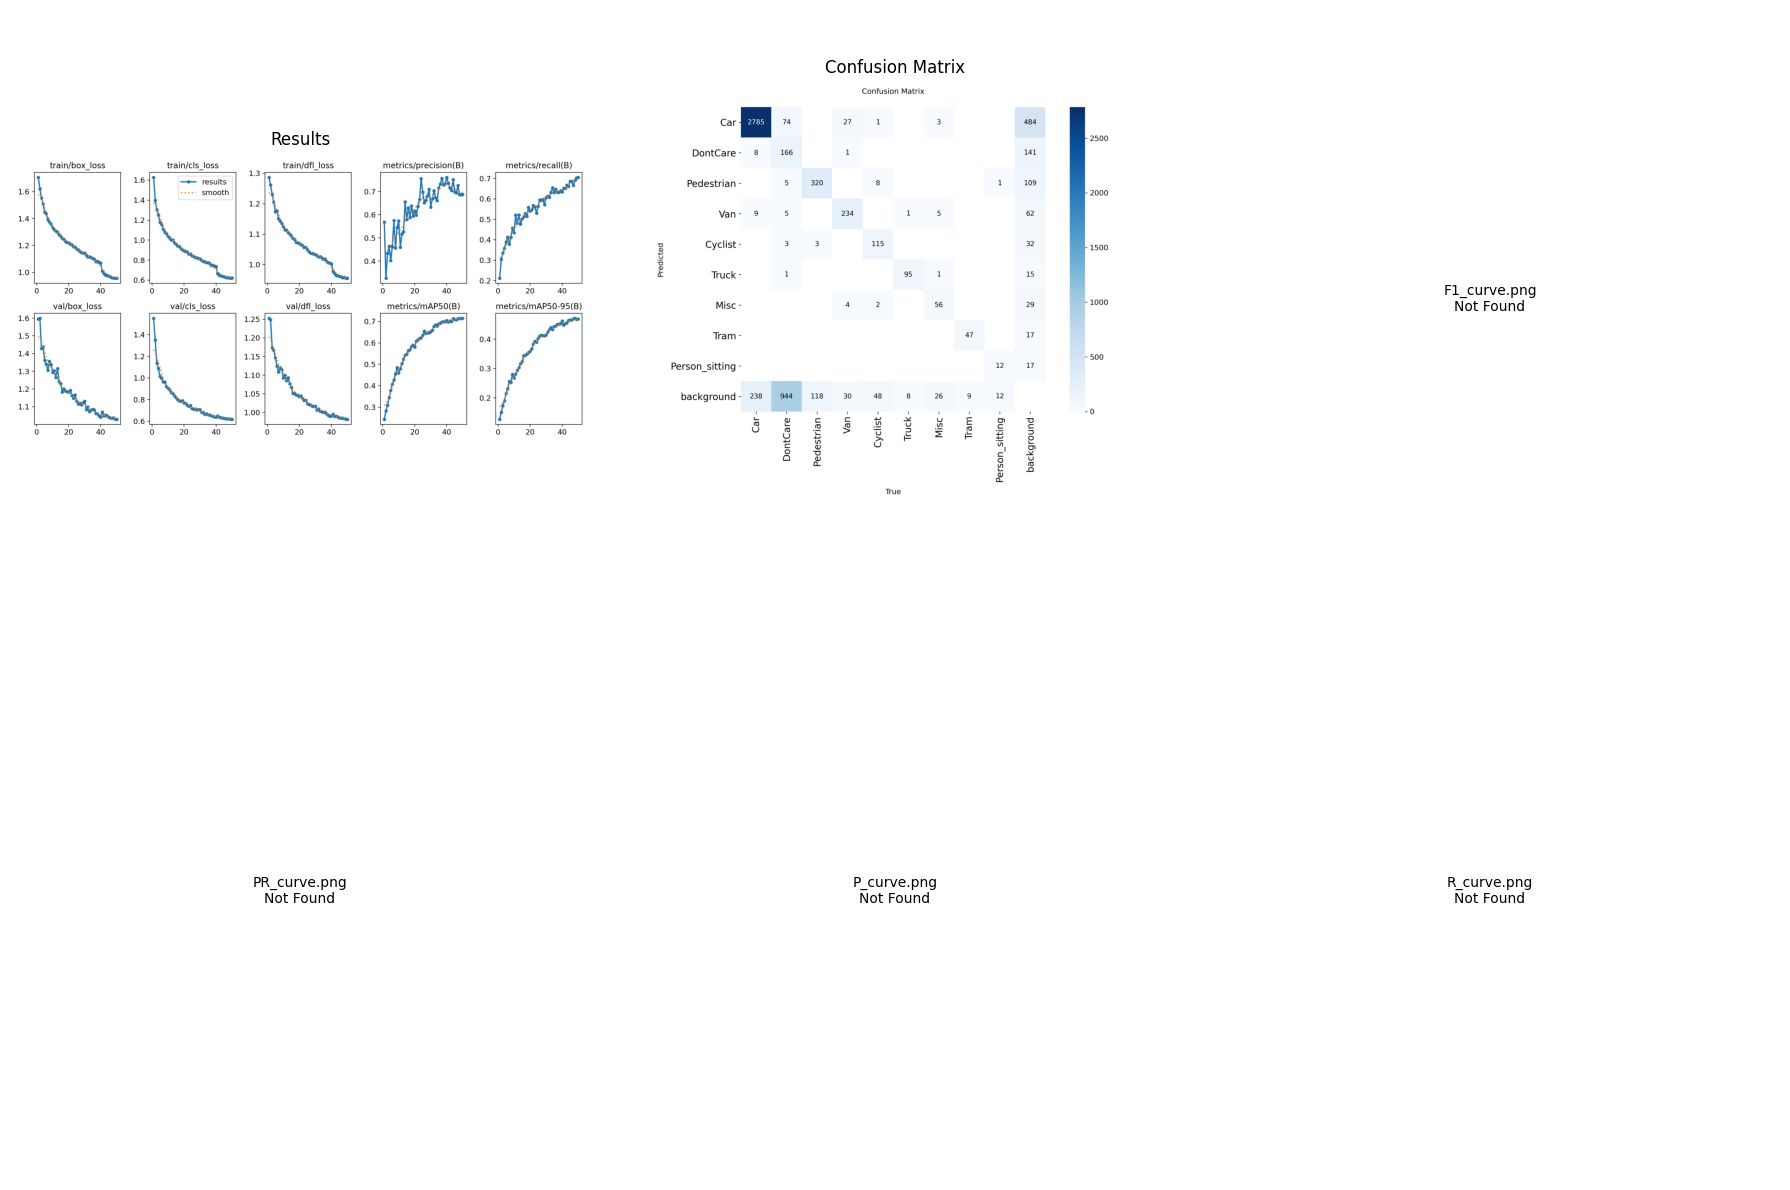

In [47]:
# Cell 18: Visualize Training Results
"""
Display training results including loss curves and performance metrics.
This helps understand how well the training performed.
"""

def display_training_results(project_path):
    """Display training results and metrics"""
    
    results_dir = Path(project_path)
    
    # Look for results images
    results_images = [
        "results.png",
        "confusion_matrix.png",
        "F1_curve.png",
        "PR_curve.png",
        "P_curve.png",
        "R_curve.png"
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, img_name in enumerate(results_images):
        if i >= len(axes):
            break
            
        img_path = results_dir / img_name
        if img_path.exists():
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(img_name.replace('.png', '').replace('_', ' ').title())
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, f"{img_name}\nNot Found", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display results if training completed
results_path = Path("kitti_yolo_training/kitti_detection_v1")
if results_path.exists():
    print("📊 Training Results Visualization:")
    display_training_results(results_path)
else:
    print("📊 Training results not available yet.")


In [48]:
# Cell 19: Performance Analysis and Model Export
"""
Analyze final model performance and export the model for deployment.
This includes detailed metrics and model optimization for production use.
"""

if best_model_path.exists():
    print("📈 Final Model Analysis:")
    
    # Load and analyze the best model
    final_model = YOLO(str(best_model_path))
    
    # Get model info
    print("\n🤖 Model Information:")
    final_model.info(verbose=True)
    
    # Export model for deployment (optional)
    print("\n📦 Exporting Model for Deployment...")
    
    export_formats = ['onnx', 'torchscript']
    
    for fmt in export_formats:
        try:
            export_path = final_model.export(format=fmt)
            print(f"   ✅ {fmt.upper()} export: {export_path}")
        except Exception as e:
            print(f"   ❌ {fmt.upper()} export failed: {e}")
    
    # Save model summary
    model_summary = {
        'dataset': 'KITTI Object Detection',
        'model': 'YOLOv8n',
        'classes': list(yolo_classes.keys()),
        'num_classes': len(yolo_classes),
        'training_samples': train_processed,
        'validation_samples': val_processed,
        'model_path': str(best_model_path),
        'config_used': training_config
    }
    
    summary_path = output_dir / "model_summary.json"
    with open(summary_path, 'w') as f:
        json.dump(model_summary, f, indent=2)
    
    print(f"✅ Model summary saved to: {summary_path}")

📈 Final Model Analysis:

🤖 Model Information:
Model summary: 129 layers, 3,012,603 parameters, 0 gradients, 8.2 GFLOPs

📦 Exporting Model for Deployment...
Ultralytics 8.3.170  Python-3.11.9 torch-2.7.1+cu118 CPU (13th Gen Intel Core(TM) i9-13980HX)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,007,403 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'kitti_yolo_training\kitti_detection_v1\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 13, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ---------------------------------------- 14.5/14.5 MB 11.7 MB/s eta 0:00:00
   --------------------------------------- 214.9/214.9 MB 11.8 MB/s eta 0:00:00
   ---------------------------------------- 6/6 [onnxruntime-gpu]

r

In [49]:
# Cell 20: Cleanup and Final Summary
"""
Clean up temporary files and provide a final summary of the training process.
This concludes the complete KITTI object detection pipeline.
"""

print("🧹 Cleanup and Final Summary")
print("="*50)

# Final summary
summary_stats = {
    'Dataset': 'KITTI Object Detection',
    'Total Samples': kitti_loader.num_samples,
    'Training Samples': len(train_indices),
    'Validation Samples': len(val_indices),
    'Classes': len(yolo_classes),
    'Model': 'YOLOv8 Nano',
    'Training Epochs': training_config['epochs'],
    'Data Directory': str(output_dir.absolute()),
    'Model Weights': str(best_model_path) if best_model_path.exists() else 'Not available'
}

print("\n📊 Project Summary:")
for key, value in summary_stats.items():
    print(f"   {key}: {value}")

print(f"\n📁 Generated Files:")
print(f"   Dataset: {output_dir}")
print(f"   Training Results: kitti_yolo_training/")
print(f"   Predictions: kitti_predictions/")

print(f"\n🎉 KITTI Object Detection Training Complete!")
print("You can now use the trained model for real-time object detection on KITTI-style images.")

# Optional: Display file sizes
print(f"\n💾 Storage Usage:")
if output_dir.exists():
    total_size = sum(f.stat().st_size for f in output_dir.rglob('*') if f.is_file())
    print(f"   Dataset size: {total_size / (1024**3):.2f} GB")

if best_model_path.exists():
    model_size = best_model_path.stat().st_size
    print(f"   Model size: {model_size / (1024**2):.2f} MB")

print("\n" + "="*50)
print("Training pipeline completed successfully! 🚀")

🧹 Cleanup and Final Summary

📊 Project Summary:
   Dataset: KITTI Object Detection
   Total Samples: 7481
   Training Samples: 6732
   Validation Samples: 749
   Classes: 9
   Model: YOLOv8 Nano
   Training Epochs: 50
   Data Directory: c:\Users\vnhar\Downloads\project1\scripts\yolo_kitti_data
   Model Weights: kitti_yolo_training\kitti_detection_v1\weights\best.pt

📁 Generated Files:
   Dataset: yolo_kitti_data
   Training Results: kitti_yolo_training/
   Predictions: kitti_predictions/

🎉 KITTI Object Detection Training Complete!
You can now use the trained model for real-time object detection on KITTI-style images.

💾 Storage Usage:
   Dataset size: 5.52 GB
   Model size: 5.93 MB

Training pipeline completed successfully! 🚀


🖼️ Ground Truth vs Predictions Visualization
🔍 Comparing Ground Truth vs Predictions on 10 images...


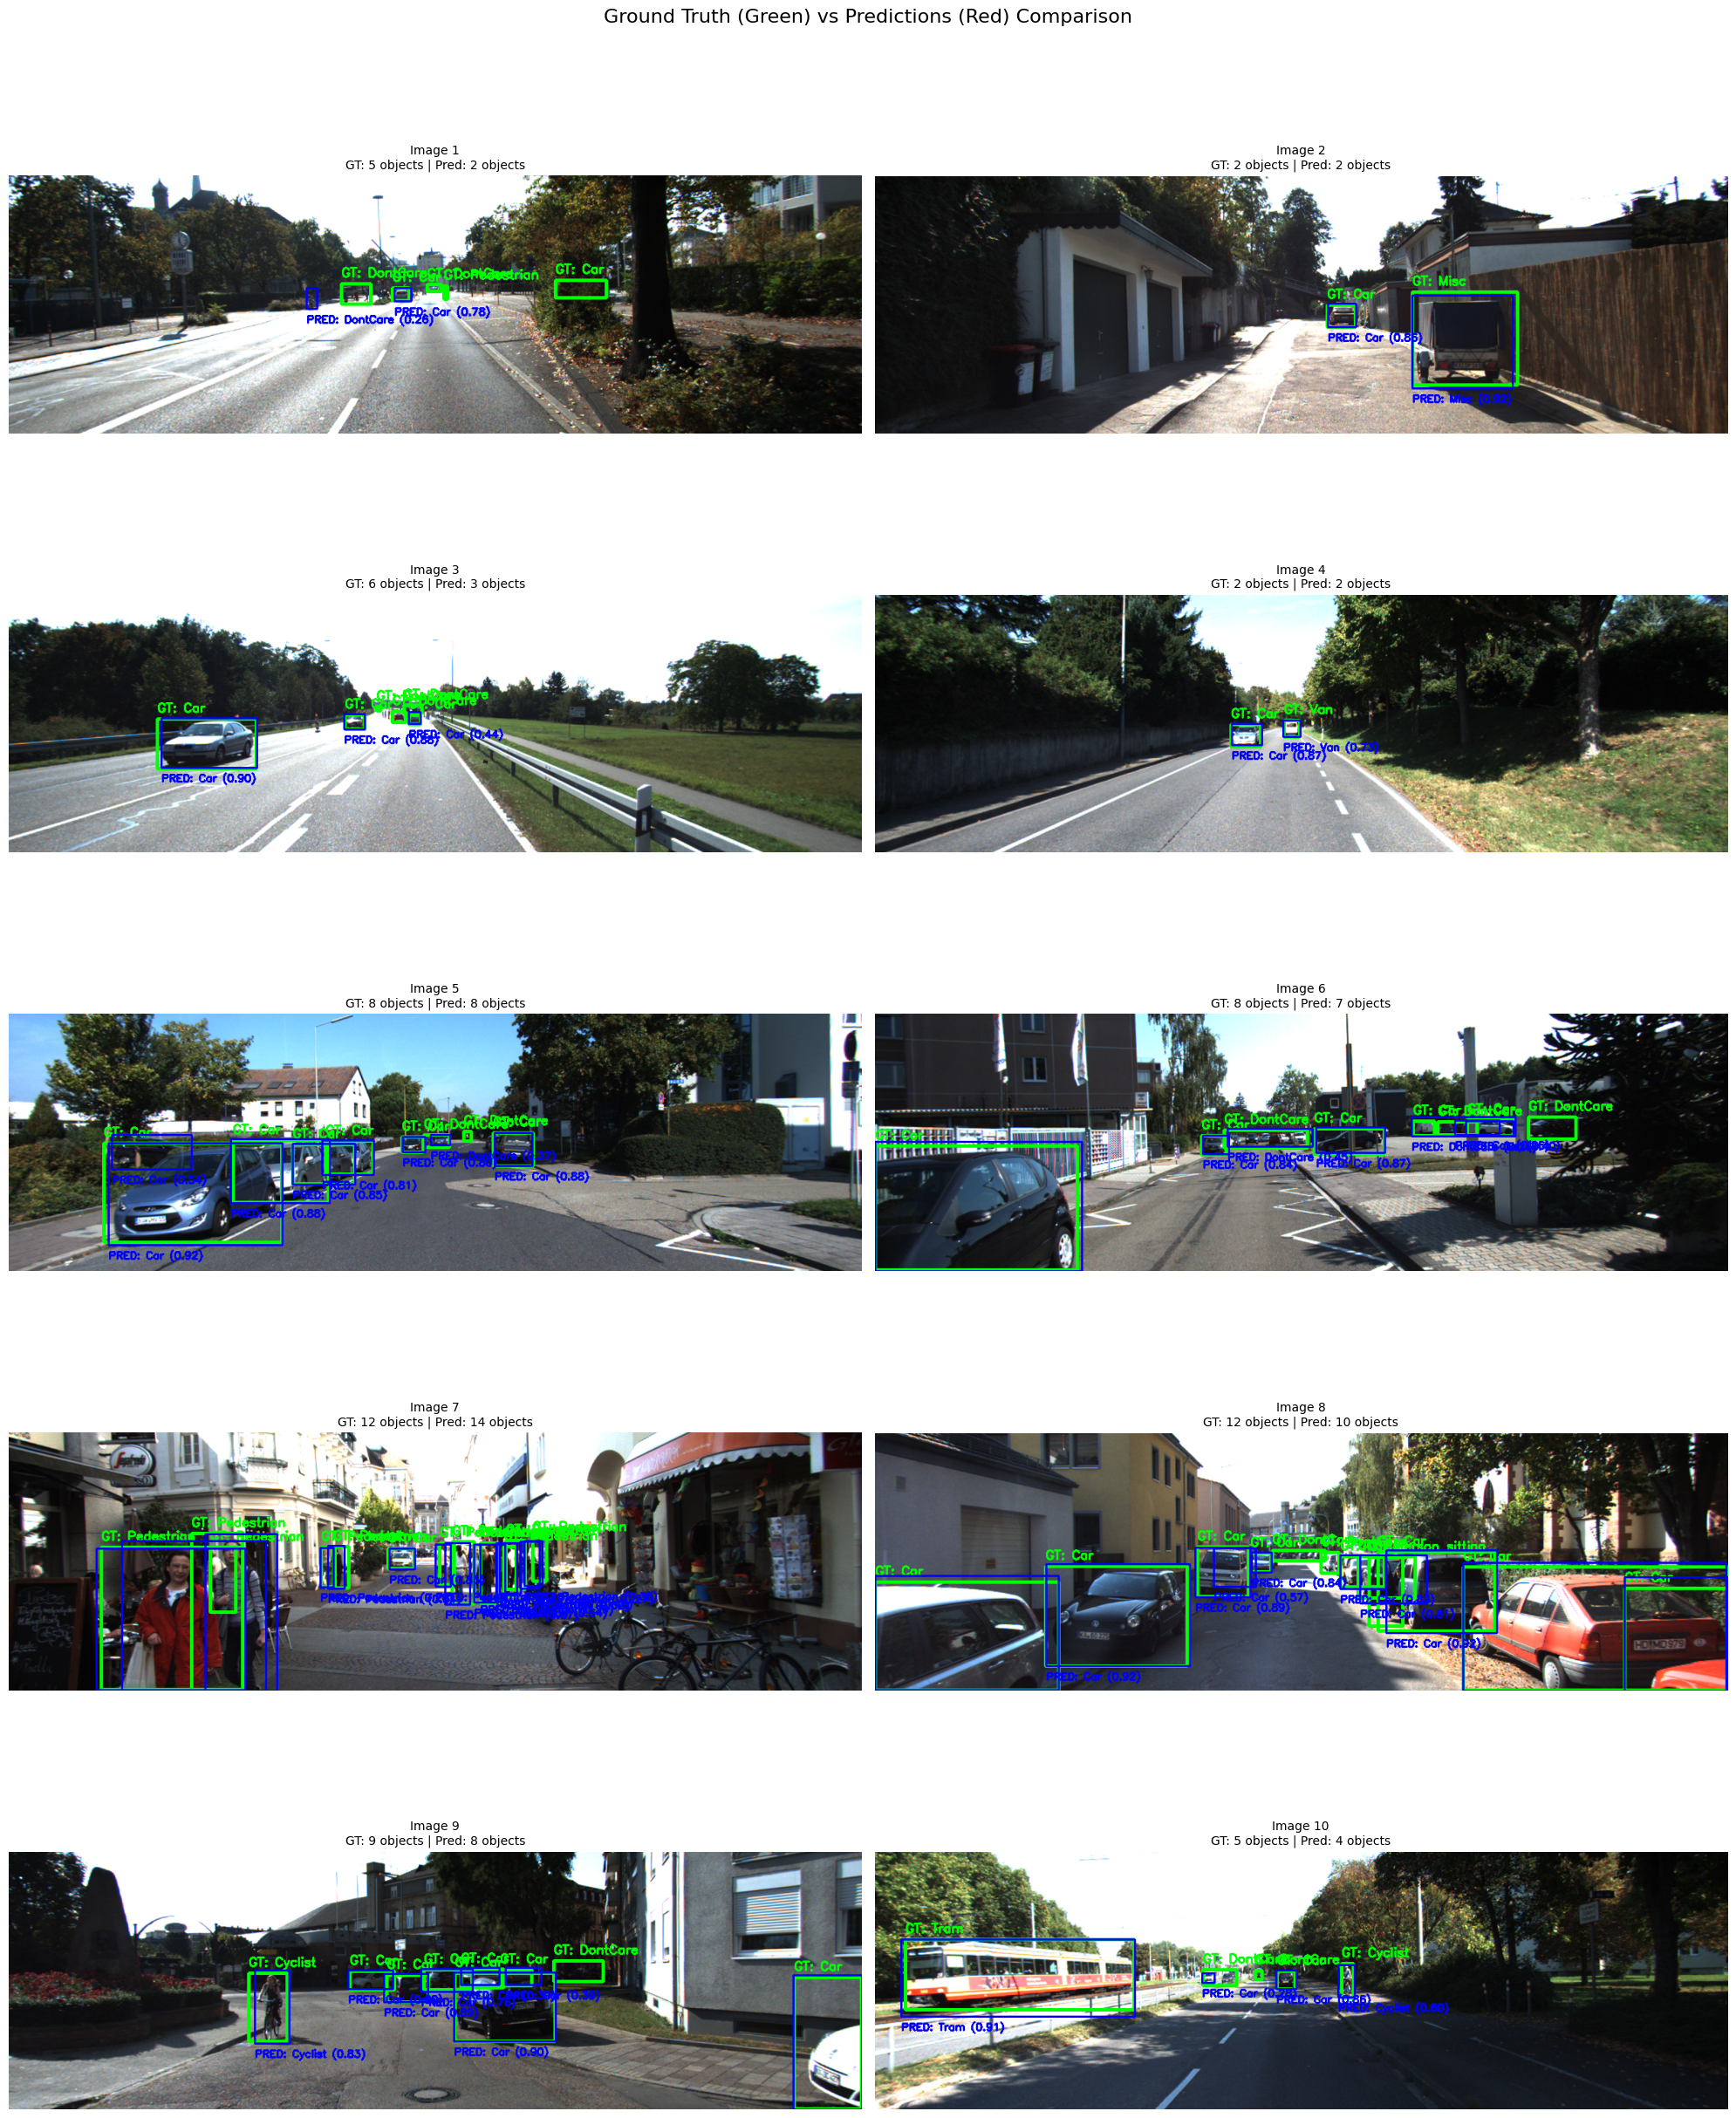


📊 Legend:
   🟢 Green boxes: Ground Truth labels
   🔴 Red boxes: Model predictions
   Numbers in parentheses: Confidence scores

📊 Calculating detection metrics on 749 validation images...


100%|██████████| 50/50 [00:01<00:00, 46.63it/s]


📈 Basic Detection Statistics:
   Total GT objects: 367
   Total predictions: 304
   Estimated recall: 0.804
   Estimated precision: 0.970

💡 Analysis Tips:
   - Green boxes show what the model should detect
   - Red boxes show what the model actually detected
   - Good predictions will have red boxes overlapping green boxes
   - Missing red boxes indicate missed detections (false negatives)
   - Red boxes without green boxes indicate false positives
   - Check confidence scores to adjust detection threshold if needed


: 

In [ ]:
# %%
# Cell 21: Visualize Ground Truth vs Predictions Comparison
"""
Display 10 sample images with both ground truth and predicted bounding boxes.
This provides a visual comparison to assess model performance on individual images.
Green boxes = Ground Truth, Red boxes = Predictions
"""

def visualize_gt_vs_predictions(val_dir, best_model, yaml_path, num_samples=10):
    """Visualize ground truth vs predictions comparison"""
    
    # Load class names from YAML
    import yaml
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    
    class_names = config['names']
    
    # Get sample validation images
    val_images = list(val_dir.glob("*.png"))
    if len(val_images) == 0:
        print("❌ No validation images found!")
        return
    
    sample_files = np.random.choice(val_images, min(num_samples, len(val_images)), replace=False)
    
    # Create subplot grid
    cols = 2
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    print(f"🔍 Comparing Ground Truth vs Predictions on {len(sample_files)} images...")
    
    for i, img_path in enumerate(sample_files):
        if i >= len(axes):
            break
        
        try:
            # Load image
            image = Image.open(img_path)
            img_array = np.array(image)
            height, width = img_array.shape[:2]
            
            # Create a copy for drawing
            img_display = img_array.copy()
            
            # Load ground truth labels
            label_path = img_path.with_suffix('.txt')
            gt_boxes = []
            
            if label_path.exists():
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                
                # Parse ground truth boxes
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, x_center, y_center, box_width, box_height = map(float, parts)
                        
                        # Convert to pixel coordinates
                        x_center *= width
                        y_center *= height
                        box_width *= width
                        box_height *= height
                        
                        x1 = int(x_center - box_width/2)
                        y1 = int(y_center - box_height/2)
                        x2 = int(x_center + box_width/2)
                        y2 = int(y_center + box_height/2)
                        
                        gt_boxes.append({
                            'class_id': int(class_id),
                            'bbox': (x1, y1, x2, y2),
                            'class_name': class_names.get(int(class_id), f"Class_{int(class_id)}")
                        })
            
            # Get model predictions
            pred_results = best_model.predict(str(img_path), conf=0.25, verbose=False)
            
            # Draw ground truth boxes (GREEN)
            for gt_box in gt_boxes:
                x1, y1, x2, y2 = gt_box['bbox']
                cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 3)  # Green for GT
                cv2.putText(img_display, f"GT: {gt_box['class_name']}", 
                           (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            
            # Draw predicted boxes (RED)
            if len(pred_results) > 0 and pred_results[0].boxes is not None:
                boxes = pred_results[0].boxes
                
                for j in range(len(boxes)):
                    # Get box coordinates
                    x1, y1, x2, y2 = boxes.xyxy[j].cpu().numpy().astype(int)
                    confidence = float(boxes.conf[j].cpu().numpy())
                    class_id = int(boxes.cls[j].cpu().numpy())
                    
                    # Draw prediction box
                    cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red for predictions
                    
                    class_name = class_names.get(class_id, f"Class_{class_id}")
                    pred_text = f"PRED: {class_name} ({confidence:.2f})"
                    cv2.putText(img_display, pred_text, 
                               (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            
            # Display the image
            axes[i].imshow(img_display)
            
            # Create title with statistics
            gt_count = len(gt_boxes)
            pred_count = len(pred_results[0].boxes) if len(pred_results) > 0 and pred_results[0].boxes is not None else 0
            
            title = f"Image {i+1}\nGT: {gt_count} objects | Pred: {pred_count} objects"
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
            
        except Exception as e:
            # Handle any errors gracefully
            axes[i].text(0.5, 0.5, f"Error processing\n{img_path.name}\n{str(e)[:50]}...", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused subplots
    for j in range(len(sample_files), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.suptitle("Ground Truth (Green) vs Predictions (Red) Comparison", 
                 fontsize=16, y=1.02)
    plt.show()
    
    # Print legend
    print("\n📊 Legend:")
    print("   🟢 Green boxes: Ground Truth labels")
    print("   🔴 Red boxes: Model predictions")
    print("   Numbers in parentheses: Confidence scores")


def calculate_detection_metrics(val_dir, best_model, yaml_path, conf_threshold=0.25):
    """Calculate basic detection metrics"""
    
    # Load class names
    import yaml
    with open(yaml_path, 'r') as f:
        config = yaml.safe_load(f)
    class_names = config['names']
    
    val_images = list(val_dir.glob("*.png"))
    
    total_gt_objects = 0
    total_pred_objects = 0
    possible_matches = 0
    
    print(f"📊 Calculating detection metrics on {len(val_images)} validation images...")
    
    for img_path in tqdm(val_images[:50]):  # Sample first 50 for speed
        try:
            # Count ground truth objects
            label_path = img_path.with_suffix('.txt')
            gt_count = 0
            
            if label_path.exists():
                with open(label_path, 'r') as f:
                    gt_count = len([line for line in f.readlines() if line.strip()])
            
            # Count predictions
            pred_results = best_model.predict(str(img_path), conf=conf_threshold, verbose=False)
            pred_count = 0
            
            if len(pred_results) > 0 and pred_results[0].boxes is not None:
                pred_count = len(pred_results[0].boxes)
            
            total_gt_objects += gt_count
            total_pred_objects += pred_count
            
            # Simple overlap estimation (for rough metrics)
            possible_matches += min(gt_count, pred_count)
            
        except Exception as e:
            continue
    
    # Calculate basic metrics
    if total_gt_objects > 0:
        recall_estimate = possible_matches / total_gt_objects
    else:
        recall_estimate = 0
        
    if total_pred_objects > 0:
        precision_estimate = possible_matches / total_pred_objects
    else:
        precision_estimate = 0
    
    print(f"\n📈 Basic Detection Statistics:")
    print(f"   Total GT objects: {total_gt_objects}")
    print(f"   Total predictions: {total_pred_objects}")
    print(f"   Estimated recall: {recall_estimate:.3f}")
    print(f"   Estimated precision: {precision_estimate:.3f}")
    
    return {
        'gt_objects': total_gt_objects,
        'pred_objects': total_pred_objects,
        'estimated_recall': recall_estimate,
        'estimated_precision': precision_estimate
    }


# Main execution
if best_model_path.exists():
    print("🖼️ Ground Truth vs Predictions Visualization")
    print("="*60)
    
    # Load the best model
    best_model = YOLO(str(best_model_path))
    
    # Visualize comparisons
    visualize_gt_vs_predictions(val_dir, best_model, yaml_path, num_samples=10)
    
    # Calculate basic metrics
    print("\n" + "="*60)
    metrics = calculate_detection_metrics(val_dir, best_model, yaml_path)
    
    print(f"\n💡 Analysis Tips:")
    print("   - Green boxes show what the model should detect")
    print("   - Red boxes show what the model actually detected")
    print("   - Good predictions will have red boxes overlapping green boxes")
    print("   - Missing red boxes indicate missed detections (false negatives)")
    print("   - Red boxes without green boxes indicate false positives")
    print("   - Check confidence scores to adjust detection threshold if needed")
    
else:
    print("❌ Best model not found. Please ensure training completed successfully.")
    print("   Expected path:", best_model_path)